In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

sys.path.append('../src')
from base import OPTIM, buildmethod, checkmethod, Encoder, HotTopic, MLP, VAE
from ntm import NTM
from qae import VQAE
from sim import make_dataset
from utils import get_kwargs, kmeans, relabel, show_dataset, shuffle

In [2]:
class RNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self._model = nn.RNN(in_channels, out_channels)

    def forward(self, X):
        pass

class RSB(HotTopic, nn.Module):
    def __init__(self, max_topics=100, *, channels=(128, 32), kld_scale=.1, optim='adam', desc='NTM', random_state=None):
        super().__init__(desc, random_state)

        self.max_topics = max_topics
        self.channels = channels
        self.kld_scale = kld_scale
        self.optim = optim

        self._n_steps = 100
    
    def _build(self, X, learning_rate=1e-2, batch_size=128, shuffle=True):
        in_channels, self._batch_size = X.shape[-1], batch_size
        self._loader = DataLoader(X, self._batch_size, shuffle)
        self._encoder = Encoder(in_channels, *self.channels)

        self._g_model = MLP(self.channels[-1], self.max_topics, final_act=self.mode, dim=-1)
        self._decoder = MLP(self.max_topics, in_channels)

        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate)
        self.train()

        return self
    
    def _step(self):
        n_topics = 2
        loss = 0.

        t, b = torch.zeros((2, n_topics, self.channels[-1]))

        for x in self._loader:
            for k in range(1, n_topics):
                t[k] == self._t_model(t[k - 1])  # TODO
                b[k] = F.softmax(x@t[k].T)
            

            z, kl = self._encoder(x, return_kld=True)

            x_ = self._decoder(self._g_model(z))  # z \in H

            x_loss = (x_ - x).square().sum().sqrt() + self.kld_scale*kl
            x_loss.backward()
            loss += x_loss.item()/self._batch_size

        self._optim.step()
        self._optim.zero_grad()

        return loss
    
    def _predict(self, X, eval=True):
        if eval:
            self.eval()

        topics = (X@self._decoder[0][0].weight.detach()).argmax(-1)

        return topics
    
    def forward(self, X, eval=True):
        topics = self._predict(X, eval)

        return topics

In [4]:
from base import Dirichlet

In [52]:
batch_size, max_topics = 32, 100
x = data[:batch_size, 3:]
n_topics = 3

encoder = Encoder(x.shape[-1], 128, 16)
rnn1 = nn.RNN(16, 16, max_topics)

z = encoder(x)
_, h = rnn1(z)
t = Dirichlet()(z@h[:n_topics - 1].T)
t.shape

torch.Size([32, 3])

torch.Size([3, 32])

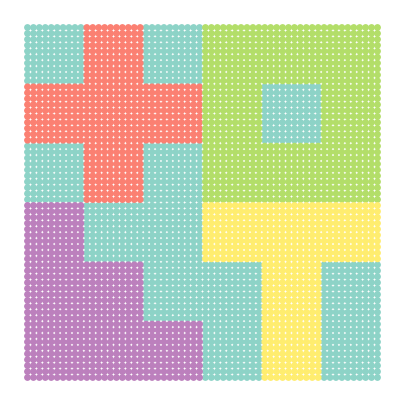

In [2]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

NTM: 100%|██████████| 1000/1000 [00:20<00:00, 48.63it/s]


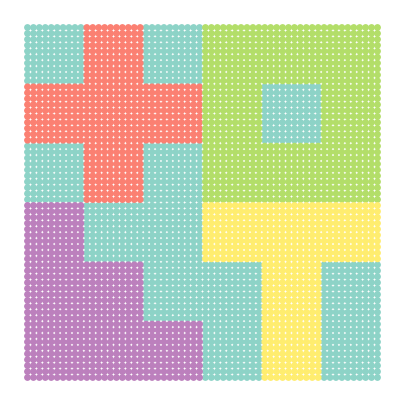

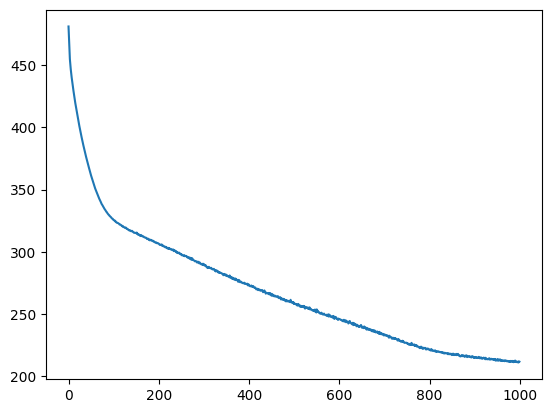

In [9]:
model = NTM(mode='softmax')
topics = model.fit_predict(data[:, 3:])
show_dataset(data, topics)
plt.show()
plt.plot(range(len(model.log_)), model.log_)
plt.show()